## Overview

In this notebook, we use the TakeCV corpus and the augmented corpus as train and validation data to train LSTM and BiLSTM classifiers. Then, we test the models on the Survey corpus.

- In the first section, we import the three corpora, create label dictionary/reverse dictionary, initiate a tokenizer, split train/validation data, and set initial hyperparameters.
- The second part is training. We train LSTMs and BiLSTM on three different sets of labels, i.e., full label (color and shape), color only and shape only, on the two training corpora.  As well, we assess the results of combining predictions from the color model and the shape model (color + shape).
- The next part is hyperparameter-tuning, using `GridSearchCV` and `KerasTuner`.
- The final section, we assess the models performance by using survey data as a test dataset.

# Import data

In [1]:
import pandas as pd

In [2]:
# read data
# TakeCV corpus
tcv = pd.read_csv('data_clean.csv')
# Augmented data
aug_all = pd.read_csv('output.csv',usecols=[1,2,3])
# Survey data
sur = pd.read_excel('processed_survey.xlsx',usecols=[0,1])

In [3]:
# process aug_data
aug_all['color'] = aug_all['color'].str.replace('grey','gray')
aug_all['label'] = aug_all['color'] + ' ' + aug_all['shape']
aug = aug_all[aug_all['label'].isin(set(tcv['label']))]

sur['label'] = sur['label'].str.replace('orange t','yellow t')

In [4]:
# split label into color and shape
tcv[['color','shape']] = tcv['label'].str.split(' ',expand=True)
sur[['color','shape']] = sur['label'].str.split(' ',expand=True)

In [5]:
df = pd.concat([tcv,sur,aug])

In [6]:
# check if split correctly
print (df['label'].value_counts())
print (df['color'].value_counts())
print (df['shape'].value_counts())
# check no. of labels
print (df['label'].nunique())
print (df['color'].nunique())
print (df['shape'].nunique())

wooden i    6934
wooden f    6169
wooden w    6167
wooden v    5939
wooden y    5431
wooden p    4628
wooden n    3848
blue i      3494
gray f      3113
wooden z    3085
blue v      2989
wooden l    2323
wooden x    2317
green w     1576
blue z      1573
pink p      1190
yellow u    1188
orange u    1179
purple n     996
orange l     616
red x        614
green t      236
yellow t     220
Name: label, dtype: int64
wooden    46841
blue       8056
gray       3113
green      1812
orange     1795
yellow     1408
pink       1190
purple      996
red         614
Name: color, dtype: int64
i    10428
f     9282
v     8928
w     7743
p     5818
y     5431
n     4844
z     4658
l     2939
x     2931
u     2367
t      456
Name: shape, dtype: int64
23
9
12


## Create label dictionary

In [7]:
import io
import json

In [83]:
all_label = sorted(list(set(df['label'])))
all_shape = sorted(list(set(df['shape'])))
all_color = sorted(list(set(df['color'])))
all_label_dict = {k: v for v, k in enumerate(all_label)}
all_shape_dict = {k: v for v, k in enumerate(all_shape)}
all_color_dict = {k: v for v, k in enumerate(all_color)}

In [84]:
# Serialize data into file:
json.dump(all_label_dict, open( "all_label_dict.json", 'w' ) )
json.dump(all_shape_dict, open( "all_shape_dict.json", 'w' ) )
json.dump(all_color_dict, open( "all_color_dict.json", 'w' ) )

In [8]:
# Read data from file:
loaded_label_dict = json.load( open( "all_label_dict.json" ) )
loaded_shape_dict = json.load( open( "all_shape_dict.json" ) )
loaded_color_dict = json.load( open( "all_color_dict.json" ) )

In [9]:
label_list = list(loaded_label_dict)
shape_list = list(loaded_shape_dict)
color_list = list(loaded_color_dict)

# Tokenizer & Models

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.optimizers import adam_v2
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
from keras.models import load_model

STOPWORDS = set(stopwords.words('english'))

In [11]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 200
# Max number of words in each text.
MAX_SEQUENCE_LENGTH = max([len(x) for x in df['text']])

In [64]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS) #, filters='!"#$%&()*+,./:;<=>?@[\]^_-`{|}~', lower=True) #delete -
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Longest sequence %s.' % MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(word_index))

Longest sequence 287.
Found 459 unique tokens.


## Save Tokenizer

In [16]:
# saving toakenizer
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [12]:
# loading tokenizer
with open('tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

## Creating a reverse dictionary

In [13]:
reverse_word_map = dict(map(reversed, loaded_tokenizer.word_index.items()))

In [14]:
def sequence_to_text(list_of_indices):
    
    text = []
    
    # Looking up words in dictionary
    for l in list_of_indices:
        if l == 0:
            pass
        else:
            w = reverse_word_map.get(l)
            text.append(w)
            
    seq = ' '.join(text)
    return seq

## Preprocessing & Split

In [15]:
SEED = 0
TEST_SIZE = 0.2

In [16]:
# TAKE-CV
tcv=tcv.replace({"label": loaded_label_dict})
tcv=tcv.replace({"shape": loaded_shape_dict})
tcv=tcv.replace({"color": loaded_color_dict})

# define X
X_tcv = loaded_tokenizer.texts_to_sequences(tcv['text'].values)
X_tcv = pad_sequences(X_tcv, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_tcv.shape)

# define Y
Y_tcv = pd.get_dummies(tcv['label']).values
Y_color_tcv = pd.get_dummies(tcv['color']).values
Y_shape_tcv = pd.get_dummies(tcv['shape']).values

print('Shape of label tensor:', Y_tcv.shape)
print('Shape of shape tensor:', Y_color_tcv.shape)
print('Shape of color tensor:', Y_shape_tcv.shape)

Shape of data tensor: (525, 287)
Shape of label tensor: (525, 23)
Shape of shape tensor: (525, 9)
Shape of color tensor: (525, 12)


In [17]:
# AUGMENTED
aug=aug.replace({"label": loaded_label_dict})
aug=aug.replace({"shape": loaded_shape_dict})
aug=aug.replace({"color": loaded_color_dict})

# define X
X_aug = loaded_tokenizer.texts_to_sequences(aug['text'].values)
X_aug = pad_sequences(X_aug, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_aug.shape)

# define Y
Y_aug = pd.get_dummies(aug['label']).values
Y_color_aug = pd.get_dummies(aug['color']).values
Y_shape_aug = pd.get_dummies(aug['shape']).values

print('Shape of label tensor:', Y_aug.shape)
print('Shape of shape tensor:', Y_color_aug.shape)
print('Shape of color tensor:', Y_shape_aug.shape)

Shape of data tensor: (65124, 287)
Shape of label tensor: (65124, 23)
Shape of shape tensor: (65124, 9)
Shape of color tensor: (65124, 12)


In [18]:
# SURVEY
sur=sur.replace({"label": loaded_label_dict})
sur=sur.replace({"shape": loaded_shape_dict})
sur=sur.replace({"color": loaded_color_dict})

# define X
X_sur = loaded_tokenizer.texts_to_sequences(sur['text'].values)
X_sur = pad_sequences(X_sur, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_sur.shape)

# define Y
Y_sur = pd.get_dummies(sur['label']).values
Y_color_sur = pd.get_dummies(sur['color']).values
Y_shape_sur = pd.get_dummies(sur['shape']).values

print('Shape of label tensor:', Y_sur.shape)
print('Shape of shape tensor:', Y_color_sur.shape)
print('Shape of color tensor:', Y_shape_sur.shape)

Shape of data tensor: (176, 287)
Shape of label tensor: (176, 21)
Shape of shape tensor: (176, 9)
Shape of color tensor: (176, 12)


In [21]:
# split TAKE-CV Sdata
X_train_tcv, X_test_tcv, Y_train_tcv, Y_test_tcv = train_test_split(X_tcv,Y_tcv, test_size = TEST_SIZE, random_state = SEED)
X_train_tcv, X_test_tcv, Y_color_train_tcv, Y_color_test_tcv = train_test_split(X_tcv,Y_color_tcv, test_size = TEST_SIZE, random_state = SEED)
X_train_tcv, X_test_tcv, Y_shape_train_tcv, Y_shape_test_tcv = train_test_split(X_tcv,Y_shape_tcv, test_size = TEST_SIZE, random_state = SEED)

print(X_train_tcv.shape,Y_train_tcv.shape, Y_color_train_tcv.shape, Y_shape_train_tcv.shape)
print(X_test_tcv.shape,Y_test_tcv.shape, Y_color_test_tcv.shape, Y_shape_test_tcv.shape)

(420, 287) (420, 23) (420, 9) (420, 12)
(105, 287) (105, 23) (105, 9) (105, 12)


In [22]:
# split AUG Sdata
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test_split(X_aug,Y_aug, test_size = TEST_SIZE, random_state = SEED)
X_train_aug, X_test_aug, Y_color_train_aug, Y_color_test_aug = train_test_split(X_aug,Y_color_aug, test_size = TEST_SIZE, random_state = SEED)
X_train_aug, X_test_aug, Y_shape_train_aug, Y_shape_test_aug = train_test_split(X_aug,Y_shape_aug, test_size = TEST_SIZE, random_state = SEED)

print(X_train_aug.shape,Y_train_aug.shape, Y_color_train_aug.shape, Y_shape_train_aug.shape)
print(X_test_aug.shape,Y_test_aug.shape, Y_color_test_aug.shape, Y_shape_test_aug.shape)

(52099, 287) (52099, 23) (52099, 9) (52099, 12)
(13025, 287) (13025, 23) (13025, 9) (13025, 12)


## Set Hyperparameters

In [23]:
EMBEDDING_DIM = 100
EPOCHS = 100
DROPOUT = 0.2
BATCH = 64
INPUT_LEN = X_train_tcv.shape[1]
EPOCHS_A = 50
BATCH_A = 512

# LSTM - full label

In [28]:
lstm_l_cv = Sequential()
lstm_l_cv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
lstm_l_cv.add(SpatialDropout1D(DROPOUT))
lstm_l_cv.add(LSTM(128))
lstm_l_cv.add(Dense(Y_train_tcv.shape[1], activation='sigmoid'))
lstm_l_cv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_l_cv.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 287, 100)          20000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 287, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                2967      
Total params: 140,215
Trainable params: 140,215
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history_lstm_l_cv = lstm_l_cv.fit(X_train_tcv, Y_train_tcv, epochs=EPOCHS, 
                    batch_size=BATCH,validation_data=(X_test_tcv,Y_test_tcv))

Epoch 1/100
7/7 [==============================] - 8s 599ms/step - loss: 3.1307 - accuracy: 0.0690 - val_loss: 3.1161 - val_accuracy: 0.1810
Epoch 2/100
7/7 [==============================] - 2s 355ms/step - loss: 3.0910 - accuracy: 0.1262 - val_loss: 3.0674 - val_accuracy: 0.0476
Epoch 3/100
7/7 [==============================] - 2s 355ms/step - loss: 3.0413 - accuracy: 0.0762 - val_loss: 3.0431 - val_accuracy: 0.0667
Epoch 4/100
7/7 [==============================] - 2s 356ms/step - loss: 3.0184 - accuracy: 0.1619 - val_loss: 3.0270 - val_accuracy: 0.1238
Epoch 5/100
7/7 [==============================] - 2s 351ms/step - loss: 2.9861 - accuracy: 0.1595 - val_loss: 3.0222 - val_accuracy: 0.1333
Epoch 6/100
7/7 [==============================] - 2s 319ms/step - loss: 2.9543 - accuracy: 0.1690 - val_loss: 2.9795 - val_accuracy: 0.0952
Epoch 7/100
7/7 [==============================] - 2s 325ms/step - loss: 2.9076 - accuracy: 0.2238 - val_loss: 2.9261 - val_accuracy: 0.2286
Epoch 8/100
7

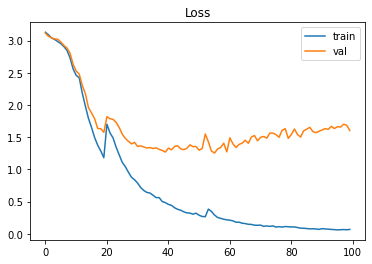

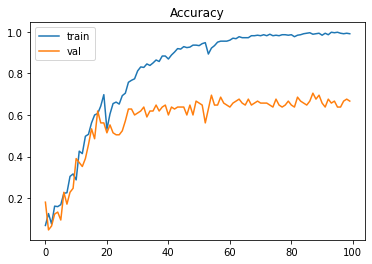

In [30]:
plt.title('Loss')
plt.plot(history_lstm_l_cv.history['loss'], label='train')
plt.plot(history_lstm_l_cv.history['val_loss'], label='val')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history_lstm_l_cv.history['accuracy'], label='train')
plt.plot(history_lstm_l_cv.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [31]:
accr = lstm_l_cv.evaluate(X_test_tcv,Y_test_tcv)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4/4 [==============================] - 0s 56ms/step - loss: 1.6052 - accuracy: 0.6667
Test set
  Loss: 1.605
  Accuracy: 0.667


In [33]:
# test with new data
new_text = ['we are looking for the brown no dark wooden piece that shape like l']
seq = loaded_tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = lstm_l_cv.predict(padded)
print(label_list[np.argmax(pred)])

wooden p


In [34]:
lstm_l_cv.save("lstm_l_cv.h5")

# LSTM - color

In [24]:
lstm_c_cv = Sequential()
lstm_c_cv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
lstm_c_cv.add(SpatialDropout1D(DROPOUT))
lstm_c_cv.add(LSTM(128))
lstm_c_cv.add(Dense(Y_color_train_tcv.shape[1], activation='sigmoid'))
lstm_c_cv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_c_cv.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 287, 100)          20000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 287, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 9)                 1161      
Total params: 138,409
Trainable params: 138,409
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history_lstm_c_cv = lstm_c_cv.fit(X_train_tcv, Y_color_train_tcv, epochs=EPOCHS, 
                    batch_size=BATCH,validation_data=(X_test_tcv,Y_color_test_tcv))

Epoch 1/100
7/7 [==============================] - 5s 409ms/step - loss: 2.1768 - accuracy: 0.2381 - val_loss: 2.1166 - val_accuracy: 0.2952
Epoch 2/100
7/7 [==============================] - 2s 228ms/step - loss: 2.0540 - accuracy: 0.2905 - val_loss: 2.0758 - val_accuracy: 0.2952
Epoch 3/100
7/7 [==============================] - 2s 227ms/step - loss: 2.0273 - accuracy: 0.2095 - val_loss: 2.0945 - val_accuracy: 0.2952
Epoch 4/100
7/7 [==============================] - 2s 240ms/step - loss: 1.9809 - accuracy: 0.3238 - val_loss: 2.0679 - val_accuracy: 0.2952
Epoch 5/100
7/7 [==============================] - 2s 226ms/step - loss: 1.9508 - accuracy: 0.2905 - val_loss: 1.9974 - val_accuracy: 0.2952
Epoch 6/100
7/7 [==============================] - 2s 229ms/step - loss: 1.9150 - accuracy: 0.2905 - val_loss: 1.9500 - val_accuracy: 0.2952
Epoch 7/100
7/7 [==============================] - 2s 242ms/step - loss: 1.8516 - accuracy: 0.2976 - val_loss: 1.8883 - val_accuracy: 0.3048
Epoch 8/100
7

Epoch 59/100
7/7 [==============================] - 3s 428ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.2956 - val_accuracy: 0.9143
Epoch 60/100
7/7 [==============================] - 2s 328ms/step - loss: 0.0438 - accuracy: 0.9905 - val_loss: 0.3265 - val_accuracy: 0.9143
Epoch 61/100
7/7 [==============================] - 2s 324ms/step - loss: 0.0326 - accuracy: 0.9952 - val_loss: 0.2954 - val_accuracy: 0.9143
Epoch 62/100
7/7 [==============================] - 2s 342ms/step - loss: 0.0807 - accuracy: 0.9857 - val_loss: 0.2679 - val_accuracy: 0.9238
Epoch 63/100
7/7 [==============================] - 2s 342ms/step - loss: 0.0982 - accuracy: 0.9738 - val_loss: 0.2507 - val_accuracy: 0.9333
Epoch 64/100
7/7 [==============================] - 3s 403ms/step - loss: 0.0387 - accuracy: 0.9976 - val_loss: 0.3664 - val_accuracy: 0.9048
Epoch 65/100
7/7 [==============================] - 4s 557ms/step - loss: 0.0622 - accuracy: 0.9881 - val_loss: 0.3221 - val_accuracy: 0.9238
Epoch 

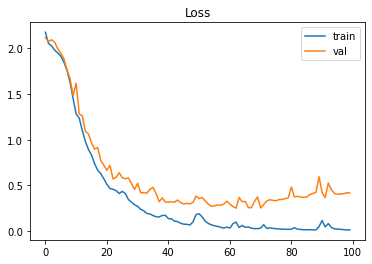

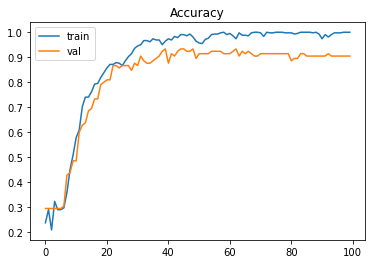

In [26]:
plt.title('Loss')
plt.plot(history_lstm_c_cv.history['loss'], label='train')
plt.plot(history_lstm_c_cv.history['val_loss'], label='val')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history_lstm_c_cv.history['accuracy'], label='train')
plt.plot(history_lstm_c_cv.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [27]:
lstm_c_cv.save("lstm_c_cv.h5")

# LSTM - shape

In [28]:
lstm_s_cv = Sequential()
lstm_s_cv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
lstm_s_cv.add(SpatialDropout1D(DROPOUT))
lstm_s_cv.add(LSTM(128))
lstm_s_cv.add(Dense(Y_shape_train_tcv.shape[1], activation='sigmoid'))
lstm_s_cv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_s_cv.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 287, 100)          20000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 287, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 138,796
Trainable params: 138,796
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history_lstm_s_cv = lstm_s_cv.fit(X_train_tcv, Y_shape_train_tcv, epochs=EPOCHS, 
                    batch_size=BATCH,validation_data=(X_test_tcv,Y_shape_test_tcv))

Epoch 1/100
7/7 [==============================] - 6s 577ms/step - loss: 2.4818 - accuracy: 0.1119 - val_loss: 2.4722 - val_accuracy: 0.2190
Epoch 2/100
7/7 [==============================] - 2s 350ms/step - loss: 2.4631 - accuracy: 0.2190 - val_loss: 2.4529 - val_accuracy: 0.1524
Epoch 3/100
7/7 [==============================] - 2s 353ms/step - loss: 2.4370 - accuracy: 0.1833 - val_loss: 2.4226 - val_accuracy: 0.1429
Epoch 4/100
7/7 [==============================] - 2s 351ms/step - loss: 2.4008 - accuracy: 0.1905 - val_loss: 2.3909 - val_accuracy: 0.2762
Epoch 5/100
7/7 [==============================] - 3s 369ms/step - loss: 2.3521 - accuracy: 0.3071 - val_loss: 2.3252 - val_accuracy: 0.2857
Epoch 6/100
7/7 [==============================] - 3s 387ms/step - loss: 2.2676 - accuracy: 0.3143 - val_loss: 2.2808 - val_accuracy: 0.3048
Epoch 7/100
7/7 [==============================] - 3s 443ms/step - loss: 2.1866 - accuracy: 0.3524 - val_loss: 2.2066 - val_accuracy: 0.2667
Epoch 8/100
7

Epoch 59/100
7/7 [==============================] - 7s 988ms/step - loss: 0.1042 - accuracy: 0.9857 - val_loss: 1.1799 - val_accuracy: 0.7143
Epoch 60/100
7/7 [==============================] - 3s 429ms/step - loss: 0.0861 - accuracy: 0.9929 - val_loss: 1.1771 - val_accuracy: 0.6952
Epoch 61/100
7/7 [==============================] - 4s 528ms/step - loss: 0.0731 - accuracy: 0.9881 - val_loss: 1.0772 - val_accuracy: 0.7238
Epoch 62/100
7/7 [==============================] - 3s 420ms/step - loss: 0.0742 - accuracy: 0.9810 - val_loss: 1.2207 - val_accuracy: 0.6952
Epoch 63/100
7/7 [==============================] - 5s 775ms/step - loss: 0.0727 - accuracy: 0.9929 - val_loss: 1.2487 - val_accuracy: 0.7048
Epoch 64/100
7/7 [==============================] - 3s 394ms/step - loss: 0.0656 - accuracy: 0.9929 - val_loss: 1.1843 - val_accuracy: 0.6952
Epoch 65/100
7/7 [==============================] - 3s 441ms/step - loss: 0.0772 - accuracy: 0.9857 - val_loss: 1.2063 - val_accuracy: 0.7238
Epoch 

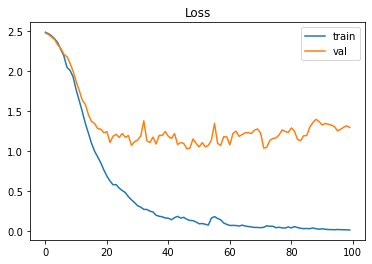

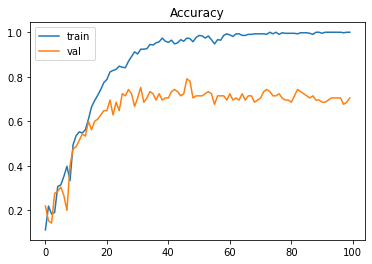

In [30]:
plt.title('Loss')
plt.plot(history_lstm_s_cv.history['loss'], label='train')
plt.plot(history_lstm_s_cv.history['val_loss'], label='val')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history_lstm_s_cv.history['accuracy'], label='train')
plt.plot(history_lstm_s_cv.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [31]:
lstm_s_cv.save("lstm_s_cv.h5")

# LSTM - combined

In [3]:
correct = 0

for pos,text in enumerate(X_train_tcv):

    text_r = text.reshape(1,-1)

    c_pred = np.argmax(lstm_c_cv.predict(text_r))
    s_pred = np.argmax(lstm_s_cv.predict(text_r))
    
    l_pred = color_list[c_pred]+' '+shape_list[s_pred]
    true = label_list[np.argmax(Y_train_tcv[pos])]
    
    #print ('Text:', sequence_to_text(text))
    #print ('Predict:',l_pred)
    #print ('True:', true)
    
    if l_pred == true:
        correct += 1
print('Train Accuracy of combined color + shape model:', correct/len(Y_train_tcv))

Train Accuracy of combined color + shape model: 1.0


In [4]:
correct = 0

for pos,text in enumerate(X_test_tcv):

    text_r = text.reshape(1,-1)

    c_pred = np.argmax(lstm_c_cv.predict(text_r))
    s_pred = np.argmax(lstm_s_cv.predict(text_r))
    
    l_pred = color_list[c_pred]+' '+shape_list[s_pred]
    true = label_list[np.argmax(Y_test_tcv[pos])]
    
    #print ('Text:', sequence_to_text(text))
    #print ('Predict:',l_pred)
    #print ('True:', true)
    
    if l_pred == true:
        correct += 1
print('Test Accuracy of combined color + shape model:', correct/len(Y_test_tcv))

Test Accuracy of combined color + shape model: 0.638095238095238


# LSTM - Aug

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=8,min_delta=0.01,mode='max')

In [46]:
lstm_aug = Sequential()
lstm_aug.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
lstm_aug.add(SpatialDropout1D(DROPOUT))
lstm_aug.add(LSTM(128))
lstm_aug.add(Dense(Y_train_aug.shape[1], activation='sigmoid'))
lstm_aug.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_aug.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 287, 100)          20000     
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 287, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 23)                2967      
Total params: 140,215
Trainable params: 140,215
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
history_lstm_aug = lstm_aug.fit(X_train_aug, Y_train_aug, epochs=EPOCHS_A, 
                    batch_size=BATCH_A,validation_data=(X_test_aug,Y_test_aug),callbacks=[early_stopping])

Epoch 1/50
101/101 [==============================] - 173s 2s/step - loss: 2.3890 - accuracy: 0.3569 - val_loss: 1.3978 - val_accuracy: 0.6392
Epoch 2/50
101/101 [==============================] - 170s 2s/step - loss: 0.5836 - accuracy: 0.8555 - val_loss: 0.2192 - val_accuracy: 0.9279
Epoch 3/50
101/101 [==============================] - 169s 2s/step - loss: 0.1730 - accuracy: 0.9340 - val_loss: 0.1326 - val_accuracy: 0.9364
Epoch 4/50
101/101 [==============================] - 481s 5s/step - loss: 0.1257 - accuracy: 0.9387 - val_loss: 0.1138 - val_accuracy: 0.9386
Epoch 5/50
101/101 [==============================] - 203s 2s/step - loss: 0.1116 - accuracy: 0.9403 - val_loss: 0.1104 - val_accuracy: 0.9374
Epoch 6/50
101/101 [==============================] - 181s 2s/step - loss: 0.1059 - accuracy: 0.9405 - val_loss: 0.1028 - val_accuracy: 0.9377
Epoch 7/50
101/101 [==============================] - 168s 2s/step - loss: 0.1013 - accuracy: 0.9414 - val_loss: 0.0995 - val_accuracy: 0.9377

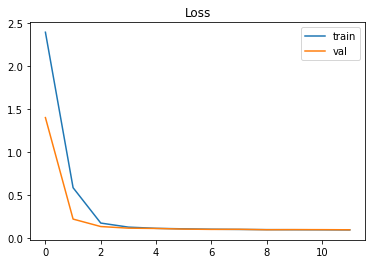

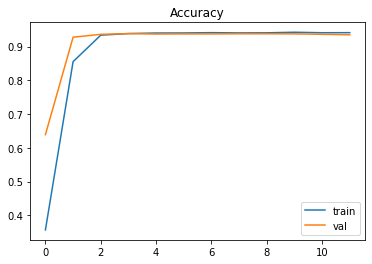

In [50]:
plt.title('Loss')
plt.plot(history_lstm_aug.history['loss'], label='train')
plt.plot(history_lstm_aug.history['val_loss'], label='val')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history_lstm_aug.history['accuracy'], label='train')
plt.plot(history_lstm_aug.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [51]:
lstm_aug.save("lstm_aug.h5")

# BiLSTM - full label

In [61]:
from tensorflow.keras.layers import Bidirectional

In [47]:
blstm_l_cv = Sequential()
blstm_l_cv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
blstm_l_cv.add(SpatialDropout1D(DROPOUT))
blstm_l_cv.add(Bidirectional(LSTM(128)))
blstm_l_cv.add(Dense(Y_train_tcv.shape[1], activation='sigmoid'))
blstm_l_cv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(blstm_l_cv.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 287, 100)          20000     
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 287, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_2 (Dense)              (None, 23)                5911      
Total params: 260,407
Trainable params: 260,407
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
history_blstm_l_cv = blstm_l_cv.fit(X_train_tcv, Y_train_tcv, epochs=EPOCHS, 
                    batch_size=BATCH,validation_data=(X_test_tcv,Y_test_tcv))

Epoch 1/100
7/7 [==============================] - 8s 618ms/step - loss: 3.1273 - accuracy: 0.0595 - val_loss: 3.1081 - val_accuracy: 0.0762
Epoch 2/100
7/7 [==============================] - 4s 570ms/step - loss: 3.0653 - accuracy: 0.0738 - val_loss: 3.0949 - val_accuracy: 0.0762
Epoch 3/100
7/7 [==============================] - 5s 722ms/step - loss: 3.0281 - accuracy: 0.1048 - val_loss: 3.0581 - val_accuracy: 0.0952
Epoch 4/100
7/7 [==============================] - 5s 664ms/step - loss: 3.0103 - accuracy: 0.1119 - val_loss: 3.0453 - val_accuracy: 0.0667
Epoch 5/100
7/7 [==============================] - 4s 647ms/step - loss: 2.9875 - accuracy: 0.1333 - val_loss: 3.0192 - val_accuracy: 0.1048
Epoch 6/100
7/7 [==============================] - 7s 1s/step - loss: 2.9393 - accuracy: 0.1571 - val_loss: 2.9825 - val_accuracy: 0.1143
Epoch 7/100
7/7 [==============================] - 5s 759ms/step - loss: 2.8946 - accuracy: 0.2000 - val_loss: 2.9441 - val_accuracy: 0.1333
Epoch 8/100
7/7 

7/7 [==============================] - 7s 965ms/step - loss: 0.1566 - accuracy: 0.9738 - val_loss: 1.3249 - val_accuracy: 0.6476
Epoch 60/100
7/7 [==============================] - 5s 647ms/step - loss: 0.1607 - accuracy: 0.9643 - val_loss: 1.3028 - val_accuracy: 0.6381
Epoch 61/100
7/7 [==============================] - 5s 723ms/step - loss: 0.1467 - accuracy: 0.9690 - val_loss: 1.2654 - val_accuracy: 0.7143
Epoch 62/100
7/7 [==============================] - 7s 982ms/step - loss: 0.1388 - accuracy: 0.9667 - val_loss: 1.2871 - val_accuracy: 0.6952
Epoch 63/100
7/7 [==============================] - 5s 654ms/step - loss: 0.1255 - accuracy: 0.9833 - val_loss: 1.3004 - val_accuracy: 0.6762
Epoch 64/100
7/7 [==============================] - 5s 707ms/step - loss: 0.1275 - accuracy: 0.9762 - val_loss: 1.2622 - val_accuracy: 0.6857
Epoch 65/100
7/7 [==============================] - 7s 994ms/step - loss: 0.1346 - accuracy: 0.9738 - val_loss: 1.3958 - val_accuracy: 0.6857
Epoch 66/100
7/7 [=

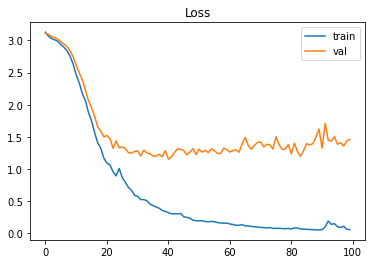

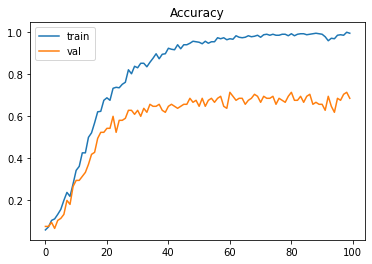

In [50]:
plt.title('Loss')
plt.plot(history_blstm_l_cv.history['loss'], label='train')
plt.plot(history_blstm_l_cv.history['val_loss'], label='val')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history_blstm_l_cv.history['accuracy'], label='train')
plt.plot(history_blstm_l_cv.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [51]:
blstm_l_cv.save("blstm_l_cv.h5")

# BiLSTM - color

In [62]:
blstm_c_cv = Sequential()
blstm_c_cv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
blstm_c_cv.add(SpatialDropout1D(DROPOUT))
blstm_c_cv.add(Bidirectional(LSTM(128)))
blstm_c_cv.add(Dense(Y_color_train_tcv.shape[1], activation='sigmoid'))
blstm_c_cv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(blstm_c_cv.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 287, 100)          20000     
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 287, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2313      
Total params: 256,809
Trainable params: 256,809
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
history_blstm_c_cv = blstm_c_cv.fit(X_train_tcv, Y_color_train_tcv, epochs=EPOCHS, 
                    batch_size=BATCH,validation_data=(X_test_tcv,Y_color_test_tcv))

Epoch 1/100
7/7 [==============================] - 8s 554ms/step - loss: 2.1462 - accuracy: 0.2762 - val_loss: 2.0788 - val_accuracy: 0.2952
Epoch 2/100
7/7 [==============================] - 4s 568ms/step - loss: 2.0339 - accuracy: 0.2905 - val_loss: 2.0578 - val_accuracy: 0.2952
Epoch 3/100
7/7 [==============================] - 3s 449ms/step - loss: 2.0140 - accuracy: 0.2905 - val_loss: 2.0684 - val_accuracy: 0.2952
Epoch 4/100
7/7 [==============================] - 3s 442ms/step - loss: 1.9870 - accuracy: 0.2905 - val_loss: 2.0581 - val_accuracy: 0.2952
Epoch 5/100
7/7 [==============================] - 3s 490ms/step - loss: 1.9396 - accuracy: 0.2905 - val_loss: 2.0285 - val_accuracy: 0.2952
Epoch 6/100
7/7 [==============================] - 4s 556ms/step - loss: 1.8864 - accuracy: 0.3024 - val_loss: 1.9706 - val_accuracy: 0.3429
Epoch 7/100
7/7 [==============================] - 5s 799ms/step - loss: 1.7861 - accuracy: 0.3833 - val_loss: 1.8451 - val_accuracy: 0.4190
Epoch 8/100
7

Epoch 59/100
7/7 [==============================] - 7s 1s/step - loss: 0.0995 - accuracy: 0.9857 - val_loss: 0.4678 - val_accuracy: 0.8857
Epoch 60/100
7/7 [==============================] - 6s 744ms/step - loss: 0.1045 - accuracy: 0.9786 - val_loss: 0.4811 - val_accuracy: 0.8571
Epoch 61/100
7/7 [==============================] - 6s 853ms/step - loss: 0.0916 - accuracy: 0.9905 - val_loss: 0.5332 - val_accuracy: 0.8571
Epoch 62/100
7/7 [==============================] - 7s 1s/step - loss: 0.1393 - accuracy: 0.9690 - val_loss: 0.4273 - val_accuracy: 0.8857
Epoch 63/100
7/7 [==============================] - 5s 765ms/step - loss: 0.0923 - accuracy: 0.9857 - val_loss: 0.3958 - val_accuracy: 0.8762
Epoch 64/100
7/7 [==============================] - 6s 930ms/step - loss: 0.1019 - accuracy: 0.9810 - val_loss: 0.4050 - val_accuracy: 0.8857
Epoch 65/100
7/7 [==============================] - 7s 779ms/step - loss: 0.1144 - accuracy: 0.9786 - val_loss: 0.4196 - val_accuracy: 0.9048
Epoch 66/100

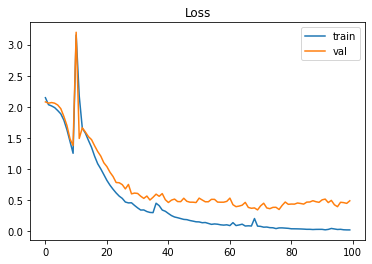

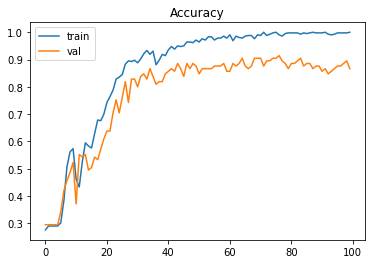

In [64]:
plt.title('Loss')
plt.plot(history_blstm_c_cv.history['loss'], label='train')
plt.plot(history_blstm_c_cv.history['val_loss'], label='val')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history_blstm_c_cv.history['accuracy'], label='train')
plt.plot(history_blstm_c_cv.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [65]:
blstm_c_cv.save("blstm_c_cv.h5")

# BiLSTM - shape

In [66]:
blstm_s_cv = Sequential()
blstm_s_cv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
blstm_s_cv.add(SpatialDropout1D(DROPOUT))
blstm_s_cv.add(Bidirectional(LSTM(128)))
blstm_s_cv.add(Dense(Y_shape_train_tcv.shape[1], activation='sigmoid'))
blstm_s_cv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(blstm_s_cv.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 287, 100)          20000     
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 287, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_3 (Dense)              (None, 12)                3084      
Total params: 257,580
Trainable params: 257,580
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
history_blstm_s_cv = blstm_s_cv.fit(X_train_tcv, Y_shape_train_tcv, epochs=EPOCHS, 
                    batch_size=BATCH,validation_data=(X_test_tcv,Y_shape_test_tcv))

Epoch 1/100
7/7 [==============================] - 12s 1s/step - loss: 2.4831 - accuracy: 0.0976 - val_loss: 2.4747 - val_accuracy: 0.1238
Epoch 2/100
7/7 [==============================] - 4s 639ms/step - loss: 2.4634 - accuracy: 0.1119 - val_loss: 2.4597 - val_accuracy: 0.1048
Epoch 3/100
7/7 [==============================] - 5s 650ms/step - loss: 2.4478 - accuracy: 0.1071 - val_loss: 2.4439 - val_accuracy: 0.1048
Epoch 4/100
7/7 [==============================] - 6s 939ms/step - loss: 2.4228 - accuracy: 0.1476 - val_loss: 2.4203 - val_accuracy: 0.1619
Epoch 5/100
7/7 [==============================] - 5s 691ms/step - loss: 2.3873 - accuracy: 0.1905 - val_loss: 2.3887 - val_accuracy: 0.2286
Epoch 6/100
7/7 [==============================] - 5s 659ms/step - loss: 2.3328 - accuracy: 0.2738 - val_loss: 2.3654 - val_accuracy: 0.1524
Epoch 7/100
7/7 [==============================] - 6s 946ms/step - loss: 2.2669 - accuracy: 0.2881 - val_loss: 2.2628 - val_accuracy: 0.2571
Epoch 8/100
7/7

Epoch 59/100
7/7 [==============================] - 4s 634ms/step - loss: 0.0804 - accuracy: 0.9833 - val_loss: 1.1686 - val_accuracy: 0.7524
Epoch 60/100
7/7 [==============================] - 5s 778ms/step - loss: 0.0868 - accuracy: 0.9738 - val_loss: 1.1594 - val_accuracy: 0.7429
Epoch 61/100
7/7 [==============================] - 5s 683ms/step - loss: 0.0756 - accuracy: 0.9810 - val_loss: 1.0903 - val_accuracy: 0.7905
Epoch 62/100
7/7 [==============================] - 4s 638ms/step - loss: 0.0669 - accuracy: 0.9833 - val_loss: 1.1087 - val_accuracy: 0.7619
Epoch 63/100
7/7 [==============================] - 5s 750ms/step - loss: 0.0877 - accuracy: 0.9810 - val_loss: 1.1173 - val_accuracy: 0.7429
Epoch 64/100
7/7 [==============================] - 7s 960ms/step - loss: 0.0744 - accuracy: 0.9857 - val_loss: 1.1728 - val_accuracy: 0.7619
Epoch 65/100
7/7 [==============================] - 5s 704ms/step - loss: 0.0670 - accuracy: 0.9810 - val_loss: 1.1628 - val_accuracy: 0.7714
Epoch 

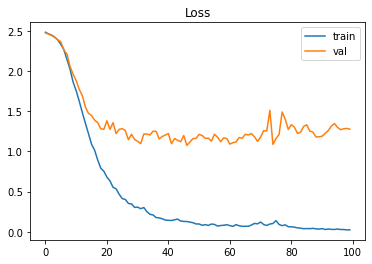

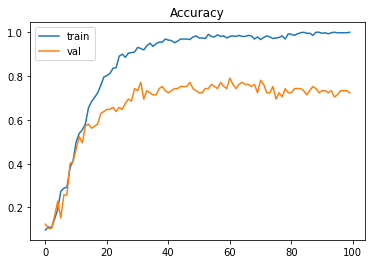

In [68]:
plt.title('Loss')
plt.plot(history_blstm_s_cv.history['loss'], label='train')
plt.plot(history_blstm_s_cv.history['val_loss'], label='val')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history_blstm_s_cv.history['accuracy'], label='train')
plt.plot(history_blstm_s_cv.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [69]:
blstm_s_cv.save("blstm_s_cv.h5")

## BiLSTM Combined

In [1]:
correct = 0

for pos,text in enumerate(X_train_tcv):

    text_r = text.reshape(1,-1)

    c_pred = np.argmax(blstm_c_cv.predict(text_r))
    s_pred = np.argmax(blstm_s_cv.predict(text_r))
    
    l_pred = color_list[c_pred]+' '+shape_list[s_pred]
    true = label_list[np.argmax(Y_train_tcv[pos])]
    
#    print ('Text:', sequence_to_text(text))
#    print ('Predict:',l_pred)
#    print ('True:', true)
    
    if l_pred == true:
        correct += 1
print('Train Accuracy of combined color + shape model:', correct/len(Y_train_tcv))

Train Accuracy of combined color + shape model: 1.0


In [2]:
correct = 0

for pos,text in enumerate(X_test_tcv):

    text_r = text.reshape(1,-1)

    c_pred = np.argmax(blstm_c_cv.predict(text_r))
    s_pred = np.argmax(blstm_s_cv.predict(text_r))
    
    l_pred = color_list[c_pred]+' '+shape_list[s_pred]
    true = label_list[np.argmax(Y_test_tcv[pos])]
    
    print ('Text:', sequence_to_text(text))
    print ('Predict:',l_pred)
    print ('True:', true)
    
    if l_pred == true:
        correct += 1
print('Test Accuracy of combined color + shape model:', correct/len(Y_test_tcv))

Test Accuracy of combined color + shape model: 0.638095238095238


# BiLSTM - Aug

In [27]:
blstm_aug = Sequential()
blstm_aug.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
blstm_aug.add(SpatialDropout1D(DROPOUT))
blstm_aug.add(Bidirectional((LSTM(128))))
blstm_aug.add(Dense(Y_train_aug.shape[1], activation='sigmoid'))
blstm_aug.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(blstm_aug.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 287, 100)          20000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 287, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 23)                5911      
Total params: 260,407
Trainable params: 260,407
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
history_blstm_aug = blstm_aug.fit(X_train_aug, Y_train_aug, epochs=EPOCHS_A, 
                    batch_size=BATCH_A,validation_data=(X_test_aug,Y_test_aug),callbacks=[early_stopping])

Epoch 1/50
101/101 [==============================] - 324s 3s/step - loss: 2.5061 - accuracy: 0.3208 - val_loss: 1.6125 - val_accuracy: 0.6005
Epoch 2/50
101/101 [==============================] - 330s 3s/step - loss: 0.6711 - accuracy: 0.8504 - val_loss: 0.2378 - val_accuracy: 0.9261
Epoch 3/50
101/101 [==============================] - 372s 4s/step - loss: 0.1833 - accuracy: 0.9337 - val_loss: 0.1390 - val_accuracy: 0.9321
Epoch 4/50
101/101 [==============================] - 341s 3s/step - loss: 0.1315 - accuracy: 0.9387 - val_loss: 0.1190 - val_accuracy: 0.9386
Epoch 5/50
101/101 [==============================] - 353s 3s/step - loss: 0.1141 - accuracy: 0.9414 - val_loss: 0.1069 - val_accuracy: 0.9368
Epoch 6/50
101/101 [==============================] - 357s 4s/step - loss: 0.1072 - accuracy: 0.9416 - val_loss: 0.1035 - val_accuracy: 0.9354
Epoch 7/50
101/101 [==============================] - 362s 4s/step - loss: 0.1027 - accuracy: 0.9415 - val_loss: 0.1021 - val_accuracy: 0.9364

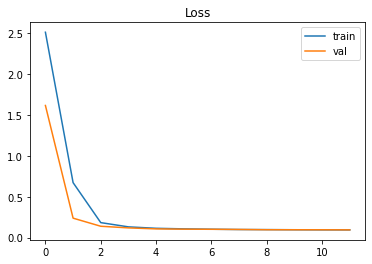

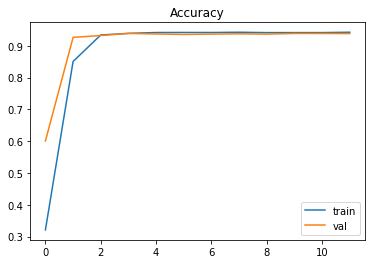

In [30]:
plt.title('Loss')
plt.plot(history_blstm_aug.history['loss'], label='train')
plt.plot(history_blstm_aug.history['val_loss'], label='val')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history_blstm_aug.history['accuracy'], label='train')
plt.plot(history_blstm_aug.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [31]:
blstm_aug.save("blstm_aug.h5")

# Testing with Survey

### TakeCV models

In [59]:
#LSTM

l_correct_full = 0
l_correct_c = 0
l_correct_s = 0
l_correct_l = 0
    
for pos,text in enumerate(X_sur):
    text_r = text.reshape(1,-1)

    f_p = np.argmax(lstm_l_cv.predict(text_r))
    c_p = np.argmax(lstm_c_cv.predict(text_r))
    s_p = np.argmax(lstm_s_cv.predict(text_r))
    
    f_pred = label_list[f_p]
    c_pred = color_list[c_p]
    s_pred = shape_list[s_p]
    l_pred = color_list[c_p]+' '+shape_list[s_p]
    
    true_f = label_list[np.argmax(Y_sur[pos])]
    true_c = color_list[np.argmax(Y_color_sur[pos])]
    true_s = shape_list[np.argmax(Y_shape_sur[pos])]
    
    if f_pred == true_f:
        l_correct_full += 1
    if c_pred == true_c:
        l_correct_c += 1
    if s_pred == true_s:
        l_correct_s += 1
    if l_pred == true_f:
        l_correct_l += 1

print('LSTM Test Accuracy of full label model:', l_correct_full/len(Y_sur))
print('LSTM Test Accuracy of color model:', l_correct_c/len(Y_color_sur))   
print('LSTM Test Accuracy of shape model:', l_correct_s/len(Y_shape_sur))   
print('LSTM Test Accuracy of combined color + shape model:', l_correct_l/len(Y_sur))

LSTM Test Accuracy of full label model: 0.30113636363636365
LSTM Test Accuracy of color model: 0.7102272727272727
LSTM Test Accuracy of shape model: 0.6079545454545454
LSTM Test Accuracy of combined color + shape model: 0.38636363636363635


In [79]:
#BiLSTM

bl_correct_full = 0
bl_correct_c = 0
bl_correct_s = 0
bl_correct_l = 0
    
for pos,text in enumerate(X_sur):
    text_r = text.reshape(1,-1)

    f_p = np.argmax(blstm_l_cv.predict(text_r))
    c_p = np.argmax(blstm_c_cv.predict(text_r))
    s_p = np.argmax(blstm_s_cv.predict(text_r))
    
    f_pred = label_list[f_p]
    c_pred = color_list[c_p]
    s_pred = shape_list[s_p]
    l_pred = color_list[c_p]+' '+shape_list[s_p]
    
    true_f = label_list[np.argmax(Y_sur[pos])]
    true_c = color_list[np.argmax(Y_color_sur[pos])]
    true_s = shape_list[np.argmax(Y_shape_sur[pos])]
    
    if f_pred == true_f:
        bl_correct_full += 1
    if c_pred == true_c:
        bl_correct_c += 1
    if s_pred == true_s:
        bl_correct_s += 1
    if l_pred == true_f:
        bl_correct_l += 1

print('BiLSTM Test Accuracy of full label model:', bl_correct_full/len(Y_sur))
print('BiLSTM Test Accuracy of color model:', bl_correct_c/len(Y_color_sur))   
print('BiLSTM Test Accuracy of shape model:', bl_correct_s/len(Y_shape_sur))   
print('BiLSTM Test Accuracy of combined color + shape model:', bl_correct_l/len(Y_sur))   

BiLSTM Test Accuracy of full label model: 0.26704545454545453
BiLSTM Test Accuracy of color model: 0.6761363636363636
BiLSTM Test Accuracy of shape model: 0.5113636363636364
BiLSTM Test Accuracy of combined color + shape model: 0.3465909090909091


### AugData Models

In [53]:
#LSTM-AUG

la_correct_full = 0
    
for pos,text in enumerate(X_sur):
    text_r = text.reshape(1,-1)

    f_p = np.argmax(lstm_l_cv.predict(text_r))
    f_pred = label_list[f_p]
    
    true_f = label_list[np.argmax(Y_sur[pos])]
    
    if f_pred == true_f:
        la_correct_full += 1

print('LSTM-aug Test Accuracy of full label model:', la_correct_full/len(Y_sur))

LSTM-aug Test Accuracy of full label model: 0.30113636363636365


In [33]:
#BiLSTM-AUG

bla_correct_full = 0
    
for pos,text in enumerate(X_sur):
    text_r = text.reshape(1,-1)

    f_p = np.argmax(blstm_aug.predict(text_r))
    f_pred = label_list[f_p]
    
    true_f = label_list[np.argmax(Y_sur[pos])]
    
    if f_pred == true_f:
        bla_correct_full += 1

print('BiLSTM-aug Test Accuracy of full label model:', bla_correct_full/len(Y_sur))

BiLSTM-aug Test Accuracy of full label model: 0.4034090909090909


# GridSearch CV

In [ ]:
# IMPORT USEFUL LIBRARIES
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def build_model(max_tokens, max_len, dropout, lr, first_neurons, second_neurons, first_activation='relu', second_activation='sigmoid'):

    vectorize_layer = TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_len,
    )
    vectorize_layer.adapt(df['text'])
    
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))   ## <=== enable str inputs
    model.add(vectorize_layer)    ## <==== add TextVectorization inside Sequential
    model.add(Embedding(max_tokens + 1, 128))
    model.add(LSTM(first_neurons, dropout=dropout, recurrent_dropout=dropout)) #units
    model.add(Dense(second_neurons, activation=first_activation)) #n_neurons #1st_activation
    model.add(Dense(1, activation=second_activation)) #2nd_actication
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# HYPERPARAMETER SEARCHING 1

param_grid = {
    "max_tokens" : [25], #, 50],
    "max_len" : [5], #, 50],
    "dropout" : [0.1, 0.2],
    "units" : [64],
    "n_neurons" : [64],
    "activation_function" : ['relu']
}
model = GridSearchCV(KerasClassifier(build_model), param_grid, cv=3, scoring='accuracy')
model.fit(np.asarray(list(df['text'])).reshape(-1,1), 
          np.asarray(list(df['label'])).reshape(-1,1), 
          epochs=128, batch_size=64, callbacks=[early_stopping], verbose=1)

In [ ]:
# HYPERPARAMETER SEARCHING 2

params = {
    "max_tokens" : [300], #, 50],
    "max_len" : [100], #, 50],
    "dropout" : [0.1, 0.2],
    'lr': [0.01],#, 0.1],
    'first_neurons':[64],
    'second_neurons':[100],
    'batch_size': [50], #,40,50],
    'epochs': [1],
#    'optimizer': [Adam],
#    'first_activation':['relu'],
#    'second_activation':['sigmoid'],
     }

model = GridSearchCV(KerasClassifier(build_model), param_grid=params, cv=3, scoring='accuracy')
model.fit(np.asarray(list(df['text'])).reshape(-1,1), 
          np.asarray(list(df['label'])).reshape(-1,1),
          #callbacks=[early_stopping], 
          verbose=2)

In [ ]:
model.best_params_

In [ ]:
pred = model.predict(np.asarray(list(df['text'])).reshape(-1,1))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(pred,np.asarray(list(df['label'])).reshape(-1,1))

# KERAS TUNER

In [ ]:
#pip install keras-tuner --upgrade

In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
    model = Sequential()
    
    hp_emb_dim = hp.Int('output_dim', min_value=10, max_value=200, step=20)
    
    model.add(Embedding(MAX_NB_WORDS, hp_emb_dim, input_length=X_train.shape[1]))

    # Tune drop_out in the first Dense layer
    # Choose an optimal value between 0.0 - 0.5 
    hp_dropout = hp.Choice('drop_out', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(SpatialDropout1D(hp_dropout))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-256
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    hp_act_func = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'])
    model.add(LSTM(hp_units))
    model.add(Dense(Y_shape.shape[1], activation=hp_act_func)) #### lok at Y

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Set Optimizer
    opt = adam_v2.Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer='adam',
                loss="categorical_crossentropy",
                metrics=['accuracy'])

    return model 

In [ ]:
#v2
from keras_tuner import HyperModel

In [ ]:
#v2
class LSTMHyperModel(HyperModel):
        
    def build(self, hp):
        model = Sequential()
        
        #hp_emb_dim = hp.Int('output_dim', min_value=10, max_value=200, step=20)
        hp_dropout = hp.Float('drop_out', min_value=0.0, max_value=0.5, step=0.1)
        hp_units = hp.Int('units', min_value=32, max_value=256, step=64)
        hp_act_func = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        

        model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
        model.add(SpatialDropout1D(hp_dropout))
        model.add(LSTM(hp_units))
        model.add(Dense(Y.shape[1], activation=hp_act_func))
        
        # Set Optimizer
        opt = adam_v2.Adam(learning_rate=hp_learning_rate)

        model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

   #     print(model.summary())
        
        return model
    
    def fit(self, hp, model):
        
        hp_batch_size = hp.Choice("batch_size", [16, 32, 64])
        return model.fit(batch_size=hp_batch_size)

In [ ]:
#RandomSearch #Hyperband #BayesianOptimization #SKlearnTuner

#v1
tuner = kt.Hyperband(model_builder, 
#v2
#tuner_2 = kt.Hyperband(LSTMHyperModel(),
                     objective='val_accuracy', #val_loss
                     max_epochs=100,
                     factor=3,
                     #directory='my_dir',
                     #project_name='intro_to_kt'
                    )

stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# v1
tuner.search(X_train, Y_shape_train, epochs=100, validation_split=0.2, callbacks=[stop_early])
best_model = tuner.get_best_models()[0]

# v2
#tuner_2.search(X_train, Y_train, callbacks=[stop_early])
#best_model_2 = tuner_2.get_best_models()[0]

In [ ]:
#tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
print(best_hps.get('output_dim'))
print(best_hps.get('drop_out'))
print(best_hps.get('units'))
print(best_hps.get('dense_activation'))
print(best_hps.get('learning_rate'))

In [ ]:
#loss, acc = 
best_model.evaluate(X_test, Y_shape_test)

#full=51(66) #color=85(91) #shape=60(66)